# Gesture Recognition
#### Submitted by
- Sameer Soin
- Ayush Mandowara

## Problem Statement

A smart tv manufactures wants to add gesture based controls to their TVs. 

To start with, the following 5 gestures are planned to be undstood by the TV:
- Thumbs Up to increase volume
- Thumbs Down to decrease volume
- Left Swipe to move 10 seconds back
- Right Swipe to move 10 seconds ahead
- Open Palm (Stop) to pause

The hardware and software to capture and take action based on the gestures already exists with the manufacturer, our focus will be on `Recognising the Gestures`.

## Data
- The data we have been provided with to train our model consists of images / frames taken in a sequence (videos that are already broken down into images) for various individuals showing the above mentioned hand gestures.  
- The data is labelled with the different classes (gestures) that need to be identified.

## Approach
To do this, we will be using `Deep Learning`. Specifically, we will be trying two approaches:
- Approach 1: 3D CNN Model  
- Approach 2: A CNN + RNN Model


---

# Imports

In [1]:
import cv2
import datetime
import numpy as np
import os
import pandas as pd
import random as rn

from keras import backend as K
import tensorflow as tf
from cv2 import imread
from sklearn.utils import shuffle

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# setting up logger to enable / disable debug statements quickly.

import sys
import logging
from importlib import reload
reload(logging)

logging.basicConfig(stream=sys.stdout, format='',
                level=logging.INFO, datefmt=None)
log = logging.getLogger(__name__)

In [4]:
# Disabling GPU usage as GPU memory is too low on local machine
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

### Fixed Random Seeds
- This helps in reproducing results in subsequent runs

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## Reading the Data
- The data is labelled
- The file paths along with labels are stored in csv files
- Data is already divided into train and validation folders 

In [4]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

project_root = "Project_data"
train_folder = os.path.join(project_root, "train")
val_folder = os.path.join(project_root, "val")

In [5]:
train_doc[0]

'WIN_20180925_18_23_57_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n'

In [6]:
len(train_doc)

663

In [7]:
train_df = pd.read_csv('Project_data/train.csv', delimiter=';', names=['Video Folder', 'Gesture', 'Label'])

In [8]:
len(train_df)

663

In [9]:
train_df.head(3)

,Video Folder,Gesture,Label
0,WIN_20180925_17_08_43_Pro_Left_Swipe_new,Left_Swipe_new,0
1,WIN_20180925_17_18_28_Pro_Left_Swipe_new,Left_Swipe_new,0
2,WIN_20180925_17_18_56_Pro_Left_Swipe_new,Left_Swipe_new,0


In [10]:
train_df.tail(3)

,Video Folder,Gesture,Label
660,WIN_20180907_16_42_05_Pro_Thumbs Up_new,Thumbs Up_new,4
661,WIN_20180907_16_42_55_Pro_Thumbs Up_new,Thumbs Up_new,4
662,WIN_20180907_16_43_39_Pro_Thumbs Up_new,Thumbs Up_new,4


In [11]:
val_df = pd.read_csv('Project_data/val.csv', delimiter=';', names=['Video Folder', 'Gesture', 'Label'])

In [12]:
val_df.head(3)

,Video Folder,Gesture,Label
0,WIN_20180925_17_17_04_Pro_Left_Swipe_new,Left_Swipe_new,0
1,WIN_20180925_17_43_01_Pro_Left_Swipe_new,Left_Swipe_new,0
2,WIN_20180925_18_01_40_Pro_Left_Swipe_new,Left_Swipe_new,0


In [13]:
val_df.tail(3)

,Video Folder,Gesture,Label
97,WIN_20180907_15_54_30_Pro_Thumbs Up_new,Thumbs Up_new,4
98,WIN_20180907_16_10_59_Pro_Thumbs Up_new,Thumbs Up_new,4
99,WIN_20180907_16_39_59_Pro_Thumbs Up_new,Thumbs Up_new,4


In [14]:
train_df = shuffle(train_df, random_state=RANDOM_SEED)

In [15]:
train_df.head(5)

,Video Folder,Gesture,Label
327,WIN_20180925_18_23_57_Pro_Thumbs_Down_new,Thumbs_Down_new,3
579,WIN_20180907_16_21_11_Pro_Stop Gesture_new,Stop Gesture_new,2
513,WIN_20180907_16_38_29_Pro_Left Swipe_new_Left ...,Left Swipe_new_Left Swipe_new,0
362,WIN_20180926_17_23_38_Pro_Thumbs_Down_new,Thumbs_Down_new,3
265,WIN_20180926_17_21_49_Pro_Stop_new,Stop_new,2


In [16]:
val_df = shuffle(val_df, random_state=RANDOM_SEED)

In [17]:
val_df.head(5)

,Video Folder,Gesture,Label
83,WIN_20180907_16_30_54_Pro_Stop Gesture_new,Stop Gesture_new,2
53,WIN_20180925_17_38_43_Pro_Thumbs_Up_new,Thumbs_Up_new,4
70,WIN_20180907_15_55_06_Pro_Right Swipe_new,Right Swipe_new,1
45,WIN_20180926_16_57_50_Pro_Thumbs_Down_new,Thumbs_Down_new,3
44,WIN_20180926_16_44_04_Pro_Thumbs_Down_new,Thumbs_Down_new,3


In [18]:
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

### Display a sequence

In [19]:
train_df.head(1)

,Video Folder,Gesture,Label
0,WIN_20180925_18_23_57_Pro_Thumbs_Down_new,Thumbs_Down_new,3


In [20]:
def get_video_path_train(idx):
    video_name = train_df.iloc[idx]['Video Folder']
    video_path = os.path.join(train_folder, video_name)
    return video_path

def get_image_list_train(idx):
    ims = os.listdir(get_video_path_train(idx))
    return ims

In [21]:
get_video_path_train(0)

'Project_data\\train\\WIN_20180925_18_23_57_Pro_Thumbs_Down_new'

In [22]:
ims = get_image_list_train(0)

In [23]:
len(ims)

30

In [24]:
def plot_sequence(train_idx, rows=3, columns=10, fig_size=(20,3), step_size=1):
    fig = plt.figure(figsize=fig_size)
    ims = get_image_list_train(train_idx)
    folder_path = get_video_path_train(train_idx)
    
    for i in range(1, columns*rows+1, step_size):
        img = imread(os.path.join(folder_path, ims[i-1]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)

    plt.show()

In [25]:
# plot_sequence(0)

In [26]:
# plot_sequence(1)

### Checking GPU Specs

In [27]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [28]:
# !nvidia-smi

# Generator

### Problems
- Since the data is huge, it cannot be processed in a single go. The machine will throw out of memory error.
- There are images in two types (dimension 120x120 and 360x), we need to make the dimensions same
- There is some room for skipping images to speed up the training process
- Data augmentation may be required to increase accuracy
- Ablation will be required to reduce analysis time

### Solution
All of the above can be achieved with the help of a custom generator which generates data in batches as per requirement.

In [29]:
class ImageProps:
    """Image class to easily store, retrieve and update properties of input images during training"""
    img_selection_via_idx = [3, 6, 9, 12, 15, 18, 21]
    img_selection_len = len(img_selection_via_idx)
    
    img_resize_height = 100
    img_resize_width = 100
    
    img_crop_width_lower_limit = 10
    img_crop_width_upper_limit = 90
    img_crop_height_lower_limit = 10
    img_crop_height_upper_limit = 90
    
    img_height = 80
    img_width = 80
    
    NUM_RGB_CHANNELS = 3
    
    def normalize_channel(self, input_channel, lower_percentile=5, upper_percentile=95):
        """To normalize input channel using percentile values"""
        lower_percentile_val = np.percentile(input_channel, lower_percentile)
        upper_percentile_val = np.percentile(input_channel, upper_percentile)
        
        numerator = input_channel-lower_percentile_val
        denominator = upper_percentile_val-lower_percentile_val
        
        normalized_channel = numerator/denominator
        
        return normalized_channel

In [30]:
img_props = ImageProps()

In [31]:
img_props.img_selection_via_idx

[3, 6, 9, 12, 15, 18, 21]

In [32]:
class VideoBatchGenerator:
    """Generator class to generate images in batches as per requirement
    
    Number of channels in RGB image is 3
    Number of gestures / output classes is 5
    
    Batch Data dimensions:
    - images have 2 dimensions (width x height)
    - rgb images have 3 channels (width x height x 3)
    - videos are sequence of rgb images (sequence of images x width x height x 3)
    - each batch has prespecified number of videos (batch size * sequence of images * width * height * 3)
    """
    batch_size = 3
    num_images_per_video = img_props.img_selection_len
    img_height = img_props.img_height
    img_width = img_props.img_width
    NUM_RGB_CHANNELS = 3
    NUM_CLASSES = 5
    SHOW_IMAGE = False
    
    def __init__(self, batch_size=batch_size):
        self.batch_size = batch_size
        
    def batch_generator(self, parent_folder_path, df):
        num_videos = len(df)
        # batch size cannot be larger than the input video sequence
        self.batch_size = min(self.batch_size, num_videos)
        num_batches = num_videos//self.batch_size
        extra_batch_size = num_videos%self.batch_size
        
        log.info(f"Source Path: {parent_folder_path}")
        log.info(f"Number of Videos: {num_videos}")
        log.info(f"Batch Size: {self.batch_size}") 
        log.info(f"Number of Batches: {num_batches}")
        log.info(f"Extra Batch Size (zero means no extra batch): {extra_batch_size}")
        
        while True:
            shuffled_df = shuffle(df, random_state=RANDOM_SEED)
            shuffled_video_folders = shuffled_df['Video Folder']
            shuffled_labels = shuffled_df['Label']
            
            log.debug(f"{shuffled_df.head()}")
            
            for batch_id in range(num_batches):
                log.debug(f"Current Batch: {batch_id}")
                batch_data = np.zeros((self.batch_size, 
                                       self.num_images_per_video, 
                                       self.img_width, self.img_height, 
                                       self.NUM_RGB_CHANNELS))
                batch_labels = np.zeros((self.batch_size, 
                                         self.NUM_CLASSES))
                
                for video_id in range(self.batch_size):
                    video_folder_id = video_id + batch_id*self.batch_size
                    video_folder_path = os.path.join(parent_folder_path, shuffled_video_folders[video_folder_id])
                    log.debug(f'id: {video_folder_id} video_folder_path: {video_folder_path}')
                    imgs_in_video = os.listdir(video_folder_path)
                    log.debug(f'first image: {imgs_in_video[0]}')
                    
                    for img_id, img_id_in_video in enumerate(img_props.img_selection_via_idx):
                        img = imgs_in_video[img_id_in_video]
                        log.debug(f'current image via selection: {img}')
                        img_path = os.path.join(video_folder_path, img)
                        log.debug(f'current image via selection [path]: {img_path}')
                        img_array = imread(img_path).astype(np.float32)
                        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                        
                        resized_image = cv2.resize(img_array, (
                                        img_props.img_resize_width, 
                                        img_props.img_resize_height,
                                        ))
                        
                        cropped_image = resized_image = resized_image[
                            img_props.img_crop_width_lower_limit:img_props.img_crop_width_upper_limit,
                            img_props.img_crop_height_lower_limit:img_props.img_crop_height_upper_limit,
                        ]
                        
                        log.debug(f"Shape of cropped image (after resize): {cropped_image.shape}")
                        
                        red_channel = cropped_image[:, :, 0]
                        green_channel = cropped_image[:, :, 1]
                        blue_channel = cropped_image[:, :, 2]
                        
                        batch_data[video_id, img_id, :, :, 0] = img_props.normalize_channel(red_channel)
                        batch_data[video_id, img_id, :, :, 1] = img_props.normalize_channel(green_channel)
                        batch_data[video_id, img_id, :, :, 2] = img_props.normalize_channel(blue_channel)
                        
                        if self.SHOW_IMAGE:
                            plt.imshow(batch_data[video_id, img_id, :, :, :])
                            plt.show()
                        
                    batch_labels[video_id, shuffled_labels[video_folder_id]] = 1
                    log.debug(f"batch data: for video:img [{video_id}:{img_id}] = {batch_data[video_id, img_id, :, :, 0]}")
                    log.debug(f"batch label: {video_id} = {batch_labels[video_id]}")
                yield batch_data, batch_labels
            
            if extra_batch_size:
                last_batch_id = batch_id + 1
                log.debug(f"Current Batch (Extra Batch): {last_batch_id}")
                batch_data = np.zeros((extra_batch_size, 
                                       self.num_images_per_video, 
                                       self.img_width, self.img_height, 
                                       self.NUM_RGB_CHANNELS))
                batch_labels = np.zeros((extra_batch_size, 
                                         self.NUM_CLASSES))
                
                for video_id in range(extra_batch_size):
                    video_folder_id = video_id + last_batch_id*self.batch_size
                    video_folder_path = os.path.join(parent_folder_path, shuffled_video_folders[video_folder_id])
                    log.debug(f'id: {video_folder_id} video_folder_path: {video_folder_path}')
                    imgs_in_video = os.listdir(video_folder_path)
                    log.debug(f'first image: {imgs_in_video[0]}')
                    
                    for img_id, img_id_in_video in enumerate(img_props.img_selection_via_idx):
                        img = imgs_in_video[img_id_in_video]
                        log.debug(f'current image via selection: {img}')
                        img_path = os.path.join(video_folder_path, img)
                        log.debug(f'current image via selection [path]: {img_path}')
                        img_array = imread(img_path).astype(np.float32)
                        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                        
                        resized_image = cv2.resize(img_array, (
                                        img_props.img_resize_width, 
                                        img_props.img_resize_height,
                                        ))
                        
                        cropped_image = resized_image[
                            img_props.img_crop_width_lower_limit:img_props.img_crop_width_upper_limit,
                            img_props.img_crop_height_lower_limit:img_props.img_crop_height_upper_limit,
                        ]
                        
                        log.debug(f"Shape of cropped image (after resize): {cropped_image.shape}")
                        
                        red_channel = cropped_image[:, :, 0]
                        green_channel = cropped_image[:, :, 1]
                        blue_channel = cropped_image[:, :, 2]
                        
                        batch_data[video_id, img_id, :, :, 0] = img_props.normalize_channel(red_channel)
                        batch_data[video_id, img_id, :, :, 1] = img_props.normalize_channel(green_channel)
                        batch_data[video_id, img_id, :, :, 2] = img_props.normalize_channel(blue_channel)
                        
                        if self.SHOW_IMAGE:
                            plt.imshow(batch_data[video_id, img_id, :, :, :])
                            plt.show()
                            
                    batch_labels[video_id, shuffled_labels[video_folder_id]] = 1
                    log.debug(f"batch data: for video:img [{video_id}:{img_id}] = {batch_data[video_id, img_id, :, :, 0]}")
                    log.debug(f"batch label: {video_id} = {batch_labels[video_id]}")
                yield batch_data, batch_labels

## Sanity Check for Batch Generator

In [33]:
# v = VideoBatchGenerator()

In [34]:
# v.batch_size

In [35]:
# v.batch_size = 5

In [36]:
# x = v.batch_generator(train_folder, train_df[0:12])

In [37]:
# train_df[0:4]

In [38]:
# v.SHOW_IMAGE = True

In [39]:
# d = next(x)

In [40]:
# d = next(x)

In [41]:
# d = next(x)

In [42]:
# d[1]

In [43]:
# d[0]

In [44]:
# val = v.batch_generator(val_folder, val_df[0:10])

In [45]:
# v.batch_size = 3

In [46]:
# y = next(val)

In [47]:
# y = next(val)

In [48]:
# y = next(val)

In [49]:
# y = next(val)

---

In [50]:
class ModelProps:
    """Properties that logically belong to a Model will be kept here"""
    current_date_time = str(datetime.datetime.now()).replace(' ', '').replace(':', '_')
    num_epochs = 3
    model_init_name = 'model_init'
    model_root_folder = "models"
    num_train_videos = None
    num_val_videos = None
    steps_per_epoch_train = None
    steps_per_epoch_val = None
    NUM_CLASSES = 5
    sample_shape = (img_props.img_selection_len, 
                    img_props.img_width, img_props.img_height, 
                    img_props.NUM_RGB_CHANNELS)
    
    def __init__(self, train_df, val_df, batch_size):
        self.num_train_videos = len(train_df)
        self.num_val_videos = len(val_df)
        self.model_folder_name = self.model_init_name + "_" + self.current_date_time + "/"
        self.model_folder_path = os.path.join(self.model_root_folder, self.model_folder_name)
        
        log.info(f"Number of Training Videos: {self.num_train_videos}")
        log.info(f"Number of Validation Videos: {self.num_val_videos}")
        
        self.steps_per_epoch_train = self.calculate_steps_per_epoch(self.num_train_videos, batch_size)
        self.steps_per_epoch_val = self.calculate_steps_per_epoch(self.num_val_videos, batch_size)
        
        log.info(f"Number of Steps (Train): {self.steps_per_epoch_train}")
        log.info(f"Number of Steps (Val): {self.steps_per_epoch_val}")
        
        log.info(f"Sample Shape: {self.sample_shape}")
        
        if not os.path.exists(self.model_root_folder):
            os.mkdir(self.model_root_folder)
        
        if not os.path.exists(self.model_folder_path):
            os.mkdir(self.model_folder_path)
        
    def calculate_steps_per_epoch(self, num_videos, batch_size):
        """Calculates steps per epoch based on the input videos and batch size"""
        steps_per_epoch = (num_videos//batch_size)+1 if num_videos%batch_size else num_videos/batch_size
        return steps_per_epoch
        
    def model_config(self):
        model_file_path = os.path.join(self.model_folder_path, 
            'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
        )
        
        checkpoint = ModelCheckpoint(
            model_file_path, 
            monitor='val_loss',
            verbose=1,
            save_best_only=False, 
            save_weights_only=False, 
            mode='auto', 
            save_freq='epoch'
        )

        LR = ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.1,
            patience=5,
            verbose=1,
            mode="auto",
            min_delta=0.0001,
            cooldown=0,
            min_lr=0,
        )
        
        callbacks_list = [LR, checkpoint]
        
        return callbacks_list

In [51]:
# m = ModelProps(train_df, val_df, 3)

# Model Building

In [52]:
import abc

class ModelBuilder(ModelProps, VideoBatchGenerator):
    def __init__(self, train_df, val_df, batch_size):
        super().__init__(train_df, val_df, batch_size)
        video_batch_generator = VideoBatchGenerator(batch_size=batch_size)
        self.train_generator = video_batch_generator.batch_generator(train_folder, train_df)
        self.val_generator = video_batch_generator.batch_generator(val_folder, val_df)
        
    @abc.abstractmethod
    def model_builder(self):
        """Building model based on Keras API"""
        model = Sequential()
        model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=self.sample_shape, padding='same'))
        model.add(BatchNormalization(center=True, scale=True))

        model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization(center=True, scale=True))

        model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization(center=True, scale=True))

        model.add(Flatten())
        model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.NUM_CLASSES, activation='softmax'))
        
        return model
    
    def model_compiler(self, optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy']):
        """Compiling model by taking in optimizer, loss, and metrics"""
        model = self.model_builder()
        model.compile(optimizer, loss, metrics)
        
        return model

In [53]:
class ModelTraining:
    def __init__(self, model_builder, model):
        self.model_builder = model_builder
        self.model = model
        
    def model_training(self):
        self.history = self.model.fit(
            self.model_builder.train_generator, 
            steps_per_epoch=self.model_builder.steps_per_epoch_train, 
            epochs=self.model_builder.num_epochs, 
            callbacks=self.model_builder.model_config(), 
            validation_data=self.model_builder.val_generator, 
            validation_steps=self.model_builder.steps_per_epoch_val, 
            class_weight=None, 
            workers=1, 
            initial_epoch=0)
        
    def model_analysis(self):
        acc = self.history.history['categorical_accuracy']
        val_acc = self.history.history['val_categorical_accuracy']

        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']

        epochs_range = range(self.model_builder.num_epochs)
        
        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')
    
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.show()

## CNN3D

In [55]:
model_builder = ModelBuilder(train_df[0:12], val_df[0:12], 3)

Number of Training Videos: 12
Number of Validation Videos: 12
Number of Steps (Train): 4.0
Number of Steps (Val): 4.0
Sample Shape: (7, 80, 80, 3)


In [56]:
simple_model_1 = model_builder.model_compiler()

In [57]:
simple_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 7, 80, 80, 16)     1312      
                                                                 
 batch_normalization (BatchN  (None, 7, 80, 80, 16)    64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 80, 80, 32)     13856     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 3, 40, 40, 32)    0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 3, 40, 40, 32)    128       
 hNormalization)                                                 
                                                        

In [58]:
training_simple_model_1 = ModelTraining(model_builder, simple_model_1)

In [59]:
# training_simple_model_1.model_training()

In [60]:
class MB(ModelBuilder):
    
    def model_builder(self):
        """Building model based on Keras API"""
        model = Sequential()
        model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=self.sample_shape, padding='same'))
        model.add(BatchNormalization(center=True, scale=True))

        model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization(center=True, scale=True))

        model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization(center=True, scale=True))

        model.add(Flatten())
        model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.NUM_CLASSES, activation='softmax'))
        
        return model

In [61]:
mm = MB(train_df, val_df, 200)

Number of Training Videos: 663
Number of Validation Videos: 100
Number of Steps (Train): 4
Number of Steps (Val): 1
Sample Shape: (7, 80, 80, 3)


In [62]:
m2 = mm.model_compiler()

In [63]:
m2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 7, 80, 80, 16)     1312      
                                                                 
 batch_normalization_3 (Batc  (None, 7, 80, 80, 16)    64        
 hNormalization)                                                 
                                                                 
 conv3d_4 (Conv3D)           (None, 7, 80, 80, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 3, 40, 40, 32)    0         
 3D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 3, 40, 40, 32)    128       
 hNormalization)                                                 
                                                      

In [64]:
mmt = ModelTraining(mm, m2)

In [66]:
# mmt.model_training()

In [ ]:
mmt.model_acc

In [ ]:
# training_simple_model_1.model_analysis()

---

In [79]:
model_builder = ModelBuilder(train_df, val_df, 300)

Number of Training Videos: 663
Number of Validation Videos: 100
Number of Steps (Train): 3
Number of Steps (Val): 1
Sample Shape: (7, 80, 80, 3)


In [80]:
# len(train_df), len(val_df)

In [81]:
simple_model_2 = model_builder.model_compiler()

In [82]:
training_simple_model_on_large_data = ModelTraining(model_builder, simple_model_2)

In [83]:
training_simple_model_on_large_data.model_training()

Source Path: Project_data\train
Number of Videos: 663
Batch Size: 300
Number of Batches: 2
Extra Batch Size (zero means no extra batch): 63
Epoch 1/3
3/3 [==============================] - ETA: 0s - loss: 89.4317 - categorical_accuracy: 0.1916  Source Path: Project_data\val
Number of Videos: 100
Batch Size: 100
Number of Batches: 1
Extra Batch Size (zero means no extra batch): 0

Epoch 00001: saving model to models\model_init_2022-01-0216_41_25.590440\model-00001-89.43166-0.19155-153.47650-0.30000.h5
3/3 [==============================] - 176s 43s/step - loss: 89.4317 - categorical_accuracy: 0.1916 - val_loss: 153.4765 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 2/3
3/3 [==============================] - ETA: 0s - loss: 20.5491 - categorical_accuracy: 0.5659 
Epoch 00002: saving model to models\model_init_2022-01-0216_41_25.590440\model-00002-20.54911-0.56587-227.84879-0.24000.h5
3/3 [==============================] - 106s 21s/step - loss: 20.5491 - categorical_accuracy: 0.56

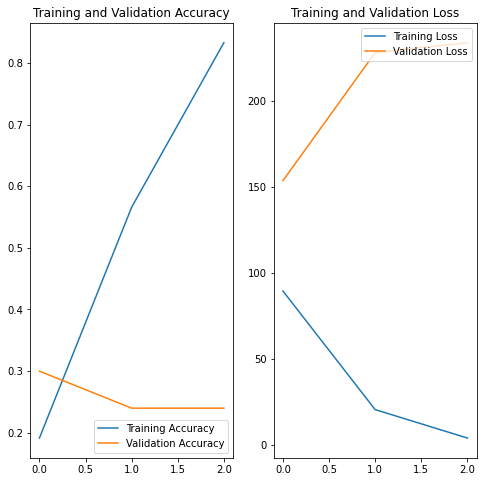

In [84]:
training_simple_model_on_large_data.model_analysis()

---

## CNN + RNN combination

In [54]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [55]:
resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(img_props.img_width,img_props.img_height,img_props.NUM_RGB_CHANNELS))

In [56]:
class RNN(ModelBuilder):
    
    def model_builder(self):
        cnn = Sequential([resnet])
        cnn.add(Conv2D(64,(2,2),strides=(1,1),padding='same'))
        cnn.add(Conv2D(16,(3,3),strides=(1,1)))
        cnn.add(Flatten())
        model = Sequential()
        model.add(TimeDistributed(cnn,input_shape=(None, img_props.img_width,img_props.img_height,img_props.NUM_RGB_CHANNELS)))
        model.add(GRU(16,input_shape=(None,30,256),return_sequences=True))
        model.add(GRU(8))
        model.add(Dense(5,activation='softmax'))
        
        return model

In [57]:
rnn = RNN(train_df, val_df, 10)

Number of Training Videos: 663
Number of Validation Videos: 100
Number of Steps (Train): 67
Number of Steps (Val): 10.0
Sample Shape: (7, 80, 80, 3)


In [58]:
rnn_model = rnn.model_compiler()

In [59]:
rnn_training = ModelTraining(rnn, rnn_model)

In [ ]:
rnn_training.model_training()

Source Path: Project_data\train
Number of Videos: 663
Batch Size: 10
Number of Batches: 66
Extra Batch Size (zero means no extra batch): 3
Epoch 1/3
67/67 [==============================] - ETA: 0s - loss: 1.4673 - categorical_accuracy: 0.3650Source Path: Project_data\val
Number of Videos: 100
Batch Size: 10
Number of Batches: 10
Extra Batch Size (zero means no extra batch): 0
